In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point
import numpy as np
from rasterio.transform import from_origin
from rasterio.plot import show
!pip install matplotlib-scalebar

In [9]:
# ------------------------------------------------------
# STEP 1: Load and Prepare Data
# ------------------------------------------------------

# Load CAT event data (CSV file with latitude, longitude, and ZIP info)
cat_data_path = "/Users/dantsai/python-notebooks/ATBS/Chapter7_mini_project/nyc_flood_loss_10000_realistic.csv"
loss_df = pd.read_csv(cat_data_path)

# Convert coordinates to geometry points
gdf = gpd.GeoDataFrame(
    loss_df,
    geometry=[Point(xy) for xy in zip(loss_df["Longitude"], loss_df["Latitude"])],
    crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

# Load ZIP shapefile (GeoJSON)
zip_geojson_path = "/Users/dantsai/python-notebooks/ATBS/Chapter7_mini_project/nyc-zip-code-tabulation-areas-polygons.geojson"
zip_gdf = gpd.read_file(zip_geojson_path)
zip_gdf = zip_gdf.to_crs(epsg=3857)  # Match coordinate system

In [10]:
# ------------------------------------------------------
# STEP 2: Clean ZIP Columns and Ensure Proper Format
# ------------------------------------------------------

gdf['ZIP'] = gdf['ZIP'].astype(str).str.zfill(5)
zip_gdf['postalCode'] = zip_gdf['postalCode'].astype(str).str.zfill(5)


In [11]:
# ------------------------------------------------------
# STEP 3: Group CAT Events by ZIP
# ------------------------------------------------------

event_counts_by_zip = gdf.groupby('ZIP').size().reset_index(name='event_count')


In [12]:
# ------------------------------------------------------
# STEP 4: Merge with ZIP GeoDataFrame (Don't fillna yet)
# ------------------------------------------------------

zip_merged = zip_gdf.merge(
    event_counts_by_zip,
    how='left',
    left_on='postalCode',
    right_on='ZIP'
)

In [13]:
# ------------------------------------------------------
# STEP 5: Create Classified Bins (with No Data Handling)
# ------------------------------------------------------

# Define bin edges and labels
bins = [0, 2, 4, 6, 8, 10, 12]
labels = ['0–2', '2–4', '4–6', '6–8', '8–10', '10–12']

# Bin event counts (NaN will remain unbinned)
zip_merged['event_bin'] = pd.cut(
    zip_merged['event_count'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False
)

# Add explicit "No Data" category
zip_merged['event_bin'] = zip_merged['event_bin'].cat.add_categories('No Data')
zip_merged['event_bin'] = zip_merged['event_bin'].fillna('No Data')

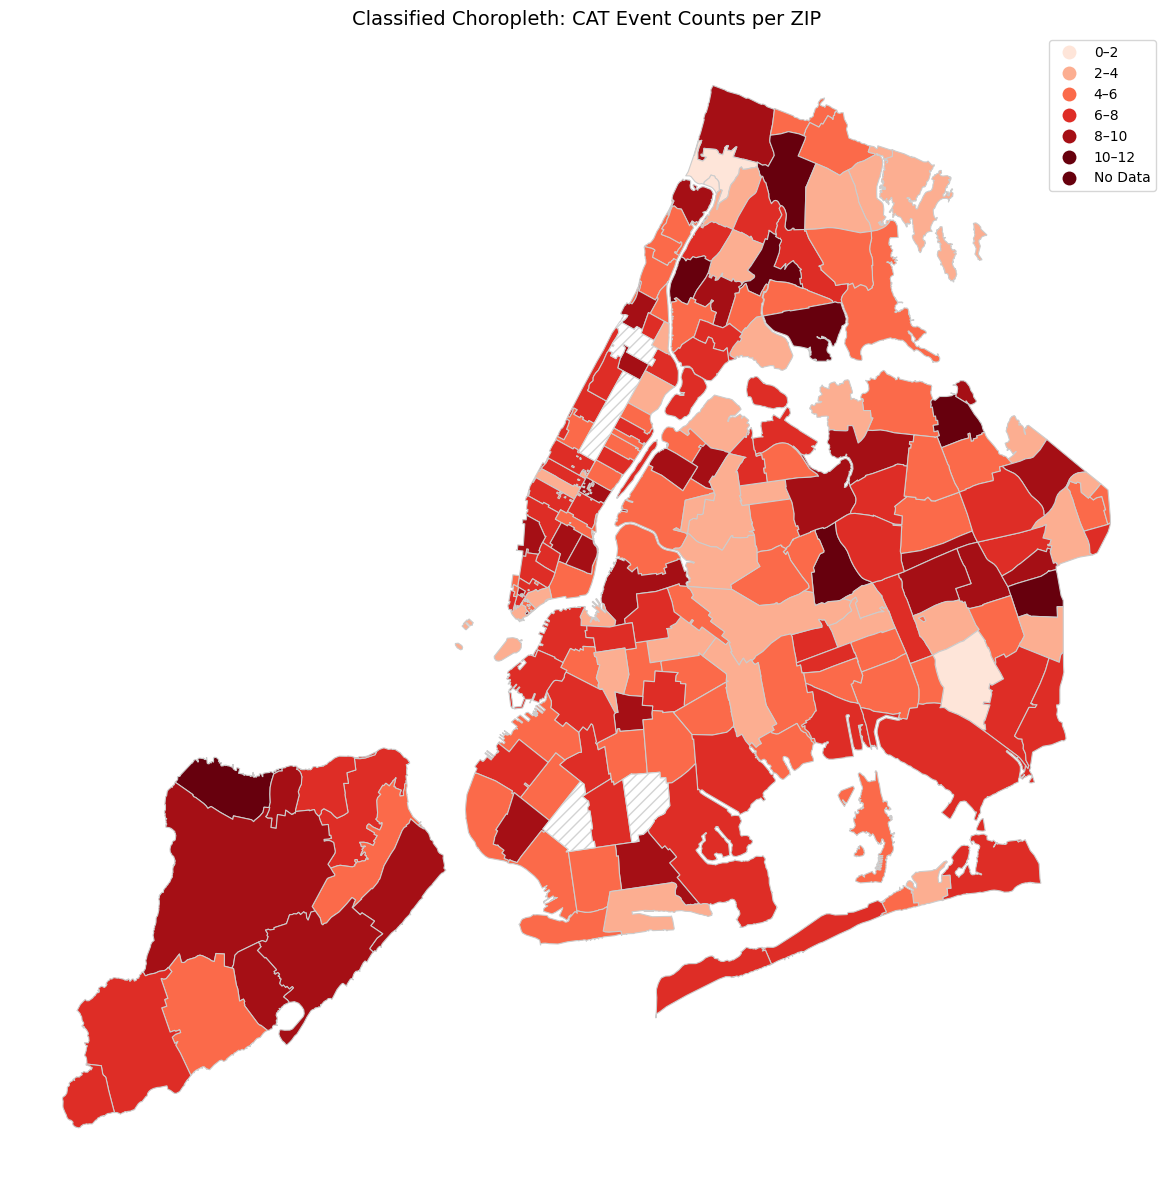

In [17]:
# ------------------------------------------------------
# STEP 6: Plot Choropleth with Hatched No-Data Areas
# ------------------------------------------------------

# Define color palette for bins (same length as labels)
cmap = mcolors.ListedColormap([
    '#fee5d9', '#fcae91', '#fb6a4a', '#de2d26', '#a50f15', '#67000d'
])
bounds = np.arange(len(labels) + 1)  # [0, 1, ..., 6]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create figure
fig, ax = plt.subplots(figsize=(12, 12))

# Plot ZIPs with data (excluding 'No Data')
zip_merged[zip_merged['event_bin'] != 'No Data'].plot(
    column='event_bin',
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    categorical=True
)

# Plot ZIPs with no data as white with hatch pattern  ///
zip_merged[zip_merged['event_bin'] == 'No Data'].plot(
    ax=ax,
    color='white',           # ← ensures blank background
    edgecolor='lightgray',   # ← optional: adds outline to no-data zones
    hatch='///',             # ← hatching pattern for visibility
    linewidth=0.8,
    label='No Data'
)

# Final plot adjustments
ax.set_title("Classified Choropleth: CAT Event Counts per ZIP", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


In [18]:
# ------------------------------------------------------
# STEP 7: Check No-Data ZIP Count (Optional Debug)
# ------------------------------------------------------

no_data_count = (zip_merged['event_bin'] == 'No Data').sum()
print(f"Number of ZIP codes with no data: {no_data_count}")

Number of ZIP codes with no data: 4


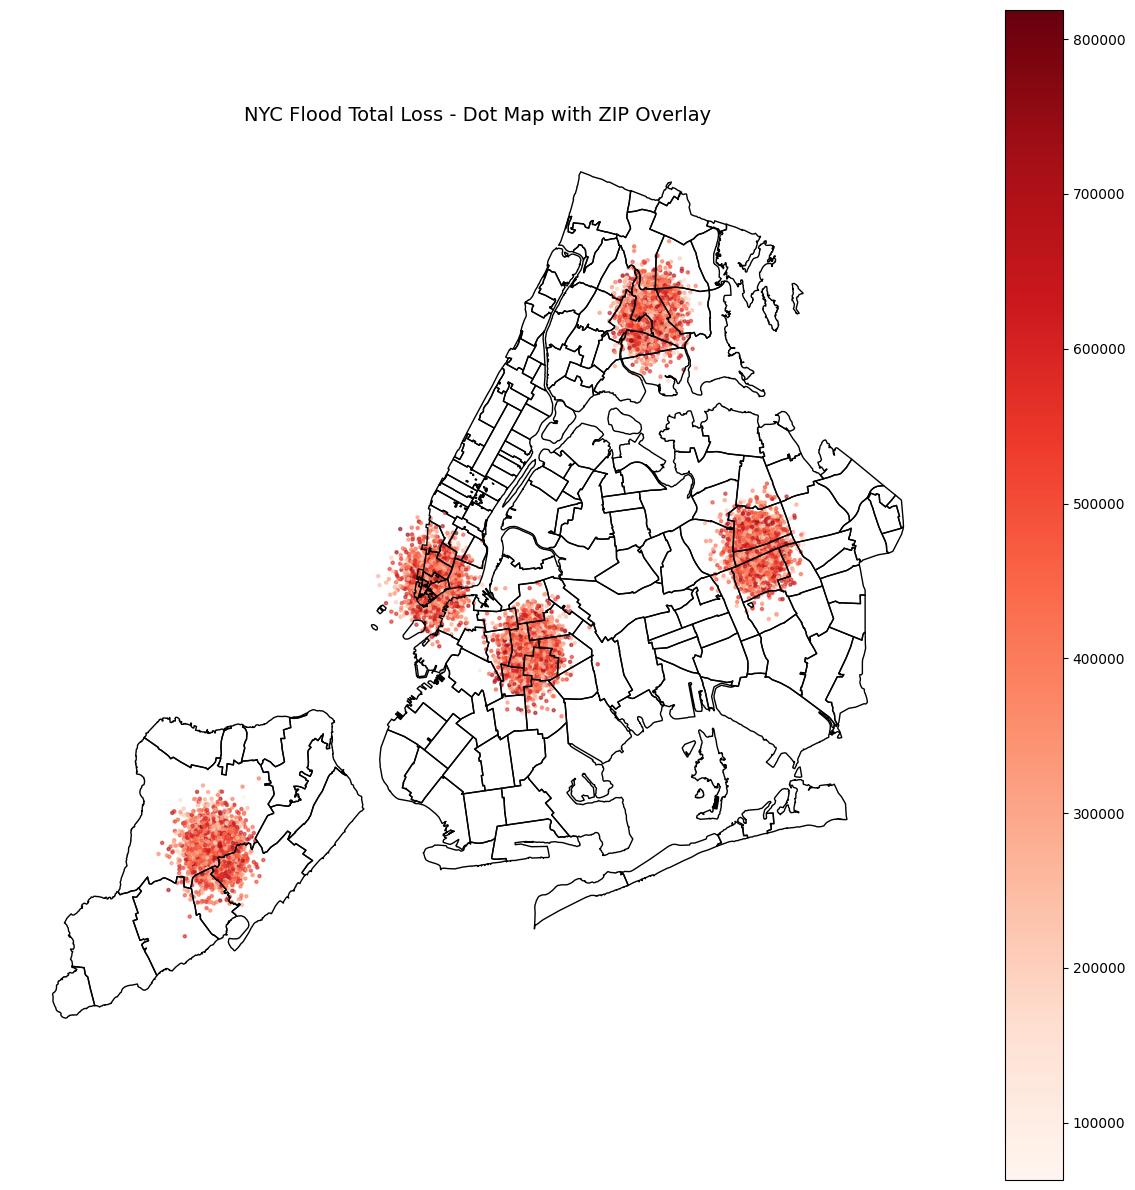

In [19]:
# ------------------------------------------------------
# STEP 8: Plot DOT MAP to Compare
# ------------------------------------------------------

# Plot total loss as dot map with ZIP outlines
loss_column = "Total Loss"
fig, ax = plt.subplots(figsize=(12, 12))

# Plot ZIP boundaries
zip_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor="black")

# Plot loss dots
scatter = gdf.plot(
    ax=ax,
    column=loss_column,
    cmap='Reds',
    markersize=5,
    alpha=0.6,
    legend=True
)

# Final formatting
ax.set_title(f"NYC Flood {loss_column} - Dot Map with ZIP Overlay", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()